In [1]:
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# архитектура модели
# гиперпараметры
# загрузчик данных
# формирование батча
# инициализировать модель
# оптимизатор
# функция потерь
# опционально шедулеры
# трейн луп

In [2]:
# hyperparams
inp_dim = 28 * 28
hidden = 256
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}' # 'cuda:0' id GPU
n_epochs = 10
batch_size = 128

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])

# зашружаем тренировочный сет
dataset_train = datasets.MNIST('.', 
                               train=True,            
                               download=True, 
                               transform=transform)

dataset_test = datasets.MNIST('.', 
                              train=False,
                              download=True, 
                              transform=transform)


In [4]:
dataset_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

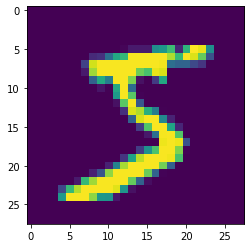

In [5]:
plt.imshow(dataset_train.data[0].detach().numpy())
plt.show()

In [6]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        # custom init nn.init.xavier_uniform(self.linear1.weight) 
        self.do = nn.Dropout(dropout_p)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.activ = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activ(x)
        x = self.do(x)
        x = self.linear2(x)

        return x


In [7]:
# Как формируется батч
# dataloader берет из Samler набор индексов и по этим индексам получает элементы из Dataset
dataset = datasets.MNIST('.', train=True, download=True)

def collate_fn(data: list):
    # data = [(pic, target)...]
    pics = []
    targets = []
    for item in data:
        pics.append(numpy.array(item[0]))
        targets.append(item[1])
    pics = torch.from_numpy(numpy.array(pics)).float() / 255
    pics = pics.view(pics.size(0), -1) # mtx 28x28 to vec 7xx
    targets = torch.from_numpy(numpy.array(targets))

    return {
        'data': pics,
        'target': targets,
    }

In [8]:
dataloader_train = \
             DataLoader(dataset_train, 
                        batch_size, 
                        shuffle=True, 
                        collate_fn=collate_fn,
                        drop_last = True,
                        )

In [9]:
dataloader_test = \
             DataLoader(dataset_test, 
                        batch_size, 
                        shuffle=True, 
                        collate_fn=collate_fn,
                        drop_last = True,
                        )

In [10]:
model = LinearModel(inp_dim, hidden, out_dim).to(device)
model.train() 
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()


In [11]:
60000 // 128 # число шагов

468

In [12]:
for epoch in range(n_epochs):
    
    for i, batch in enumerate(dataloader_train):
        optim.zero_grad()

        predict = model(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    
    for i, batch in enumerate(dataloader_test):
        test_loss = 0
        model.eval()
        
        predict = model(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        test_loss += loss
        
    model.train()
    print(f'test loss: {test_loss/i}')
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')

epoch: 0, step: 0, loss: 2.305283546447754
epoch: 0, step: 200, loss: 1.6423307657241821
epoch: 0, step: 400, loss: 0.9670810699462891
test loss: 0.010696891695261002
epoch: 1, step: 0, loss: 0.8696702718734741
epoch: 1, step: 200, loss: 0.7272803783416748
epoch: 1, step: 400, loss: 0.5737642049789429
test loss: 0.006861729081720114
epoch: 2, step: 0, loss: 0.5209494233131409
epoch: 2, step: 200, loss: 0.4200119972229004
epoch: 2, step: 400, loss: 0.7565553784370422
test loss: 0.005211362149566412
epoch: 3, step: 0, loss: 0.5252307653427124
epoch: 3, step: 200, loss: 0.6123530864715576
epoch: 3, step: 400, loss: 0.45609501004219055
test loss: 0.004006021656095982
epoch: 4, step: 0, loss: 0.28181084990501404
epoch: 4, step: 200, loss: 0.3171286880970001
epoch: 4, step: 400, loss: 0.37860628962516785
test loss: 0.00558296125382185
epoch: 5, step: 0, loss: 0.4202302098274231
epoch: 5, step: 200, loss: 0.24414017796516418
epoch: 5, step: 400, loss: 0.2738012671470642
test loss: 0.003461254

# Новый раздел

In [13]:
# hyperparams
input_ch = 1
out_ch = 1
hidden_ch = 128
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [14]:
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

testloader = torch.utils.data.DataLoader(dataset_test, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

In [15]:
size = next(iter(trainloader))[0].shape

In [16]:
class ConvDO(nn.Module):
    def __init__(self, input_ch, output_ch, kernel_size, stride, padding, 
                 dropout_p=0.1):
        super().__init__()
        self.conv = nn.Conv2d(
            input_ch, 
            output_ch, 
            kernel_size=kernel_size,
            stride=stride,
            padding=padding, 
        )
        self.bnorm = nn.BatchNorm2d(num_features=input_ch)
        self.do = nn.Dropout(dropout_p)

    def forward(self, x):

        return self.do(self.conv(x))
#torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, 
#groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
class ConvModel(nn.Module):
    def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
        super().__init__()
        decrease = 2
        self.conv1 = ConvDO(input_ch, hidden_ch, 5, 2, 2) # уменьшим размер выходной фичматрицы в 2 раза
        # TODO еще уменьшить размер фичматрицы
        self.conv2 = ConvDO(hidden_ch, hidden_ch, 5, 2, 2)
        decrease += 2
        self.conv3 = ConvDO(hidden_ch, hidden_ch, 3, 1, 1)
        # TODO увеличить число выходных каналов
        self.conv4 = ConvDO(hidden_ch, out_ch, 3, 1, 1)
        self.linear = nn.Linear(
            int(size[-2]/decrease) * int(size[-1]/decrease) * out_ch, # TODO поправить при изменении числа каналов и размера фич матриц
            output_dim,
        )  
        self.activ = nn.ReLU()    

    def forward(self, x):
        x = self.activ(self.conv1(x))
        x = self.activ(self.conv2(x))
        x = self.activ(self.conv3(x))
        x = self.activ(self.conv4(x))
        x = self.linear(x.view(x.size(0), -1))

        return x

In [17]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.CrossEntropyLoss()

In [18]:
for epoch in range(n_epochs):
    for i, batch in tqdm(enumerate(trainloader)):
        inputs, labels = batch
        optim.zero_grad()

        predict = model_conv(inputs.to(device))
        loss = loss_func(predict, labels.to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    model_conv.train()
    # print('test loss:', loss_test / i)
    #save every epoch

    torch.save(model_conv.state_dict(), f'./chkpt_cv1_conv_{epoch}.pth')


0it [00:00, ?it/s]

epoch: 0, step: 0, loss: 2.3080451488494873
epoch: 0, step: 200, loss: 0.2397243082523346
epoch: 0, step: 400, loss: 0.13052205741405487


0it [00:00, ?it/s]

epoch: 1, step: 0, loss: 0.06417137384414673
epoch: 1, step: 200, loss: 0.11163777112960815
epoch: 1, step: 400, loss: 0.04898819699883461


0it [00:00, ?it/s]

epoch: 2, step: 0, loss: 0.02242782898247242
epoch: 2, step: 200, loss: 0.05584092065691948
epoch: 2, step: 400, loss: 0.02946329116821289


0it [00:00, ?it/s]

epoch: 3, step: 0, loss: 0.04704560339450836
epoch: 3, step: 200, loss: 0.04987507686018944
epoch: 3, step: 400, loss: 0.048207320272922516


0it [00:00, ?it/s]

epoch: 4, step: 0, loss: 0.016617486253380775
epoch: 4, step: 200, loss: 0.019169732928276062
epoch: 4, step: 400, loss: 0.05116046220064163


0it [00:00, ?it/s]

epoch: 5, step: 0, loss: 0.014648625627160072
epoch: 5, step: 200, loss: 0.056249890476465225
epoch: 5, step: 400, loss: 0.013876369222998619


0it [00:00, ?it/s]

epoch: 6, step: 0, loss: 0.02524566650390625
epoch: 6, step: 200, loss: 0.01943655125796795
epoch: 6, step: 400, loss: 0.05343518406152725


0it [00:00, ?it/s]

epoch: 7, step: 0, loss: 0.008249838836491108
epoch: 7, step: 200, loss: 0.019473636522889137
epoch: 7, step: 400, loss: 0.05051569640636444


0it [00:00, ?it/s]

epoch: 8, step: 0, loss: 0.059006962925195694
epoch: 8, step: 200, loss: 0.008025730960071087
epoch: 8, step: 400, loss: 0.011486037634313107


0it [00:00, ?it/s]

epoch: 9, step: 0, loss: 0.004967410583049059
epoch: 9, step: 200, loss: 0.08115038275718689
epoch: 9, step: 400, loss: 0.02615666389465332
